In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import auc, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, precision_recall_curve

In [ ]:
def load_data(dataset_index):
    print(f"Processing dataset {dataset_index}...")
    
    base_path = '/project/zhiwei/cq5/PythonWorkSpace/TCRPrediction/tc-hard/dataset/new_split/pep+cdr3b'
    embed_base_path = '/scratch/zhiwei/hf78/TCRproject/vibtcr/data/embedNA/val' 
    df_train = pd.read_csv(f'{base_path}/train/only-neg-assays/train-{dataset_index}.csv', low_memory=False)
    df_val = pd.read_csv(f'{base_path}/validation/only-neg-assays/validation-{dataset_index}.csv', low_memory=False)
    df_test = pd.read_csv(f'{base_path}/test/only-neg-assays/test-{dataset_index}.csv', low_memory=False)
    train_pep_mol = np.load(f'{embed_base_path}/train{dataset_index}_pep_mol.npy')
    val_pep_mol = np.load(f'{embed_base_path}/val{dataset_index}_pep_mol.npy')
    test_pep_mol = np.load(f'{embed_base_path}/test{dataset_index}_pep_mol.npy')
    train_cdr3 = np.load(f'{embed_base_path}/train{dataset_index}_CDR3_esm.npy')
    val_cdr3 = np.load(f'{embed_base_path}/val{dataset_index}_CDR3_esm.npy')
    test_cdr3 = np.load(f'{embed_base_path}/test{dataset_index}_CDR3_esm.npy')

    X_train = np.column_stack((train_pep_mol, train_cdr3))
    X_val = np.column_stack((val_pep_mol, val_cdr3))
    X_test = np.column_stack((test_pep_mol, test_cdr3))

    y_train = df_train['label']
    y_val = df_val['label']
    y_test = df_test['label']
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [23]:
from sklearn.datasets import make_blobs
from sklearn.manifold import TSNE
# import umap
import matplotlib.pyplot as plt
import seaborn as sns


In [24]:
dataset_index = 4
X_train, y_train, X_val, y_val, X_test, y_test = load_data(dataset_index)

Processing dataset 4...


In [25]:
X_train.shape

(165775, 1248)

In [26]:
pep_train = X_train[:, :748].copy()
tcr_train = X_train[:, 748:].copy()

In [27]:
from collections import Counter

unique_rows, counts = np.unique(pep_train, axis=0, return_counts=True)
row_counts = Counter({tuple(row): count for row, count in zip(unique_rows, counts)})

In [28]:
most_seq = [seq for seq, c in row_counts.most_common(20)]

In [29]:
most_seq_sum = np.sum(np.array(most_seq), axis = 1)

In [ ]:
num_rows = X_train.shape[0]
sampled_indices = np.random.choice(num_rows, size=1000, replace=True)
X = X_train[sampled_indices]
y = y_train[sampled_indices]

X.shape, y.shape

((1000, 1248), (1000,))

In [32]:
u, c = np.unique(y, return_counts=True)
u, c

(array([0, 1]), array([614, 386]))

In [33]:
import numpy as np

X_random = np.random.randn(1000, 1248)
y_random = np.random.choice([0, 1], size=1000)

In [34]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def hopkins_statistic(X):
    n, d = X.shape
    m = int(0.1 * n)  # Use 10% of the data as the sample size
    nbrs = NearestNeighbors(n_neighbors=1, metric = "euclidean").fit(X)
    
    rand_X = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    
    u_dist, _ = nbrs.kneighbors(rand_X, n_neighbors=2)
    u_dist = u_dist[:, 1]  # Distance to the nearest neighbor in the actual data
    w_dist, _ = nbrs.kneighbors(X[np.random.choice(n, m, replace=False)], n_neighbors=2)
    w_dist = w_dist[:, 1]  # Distance to the nearest neighbor in the sample
    
    H = sum(u_dist) / (sum(u_dist) + sum(w_dist))
    return H


In [35]:
# Generate sample data with 3 clusters
# X, y = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)

# t-SNE transformation
tsne = TSNE(n_components=2, random_state=42)

X_tsne = tsne.fit_transform(X)
X_random_tsne = tsne.fit_transform(X_random)

In [36]:
with_pretrain_h_score = hopkins_statistic(X_tsne)
print(f"with pretraining Hopkins Score: {with_pretrain_h_score}")

without_pretrain_h_score = hopkins_statistic(X_random)
print(f"without pretraining Hopkins Score: {without_pretrain_h_score}")

with pretraining Hopkins Score: 0.8944399801580064
without pretraining Hopkins Score: 0.6073758203773755


In [37]:
# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# rc('font',**{'family':'serif','serif':['Times New Roman']})

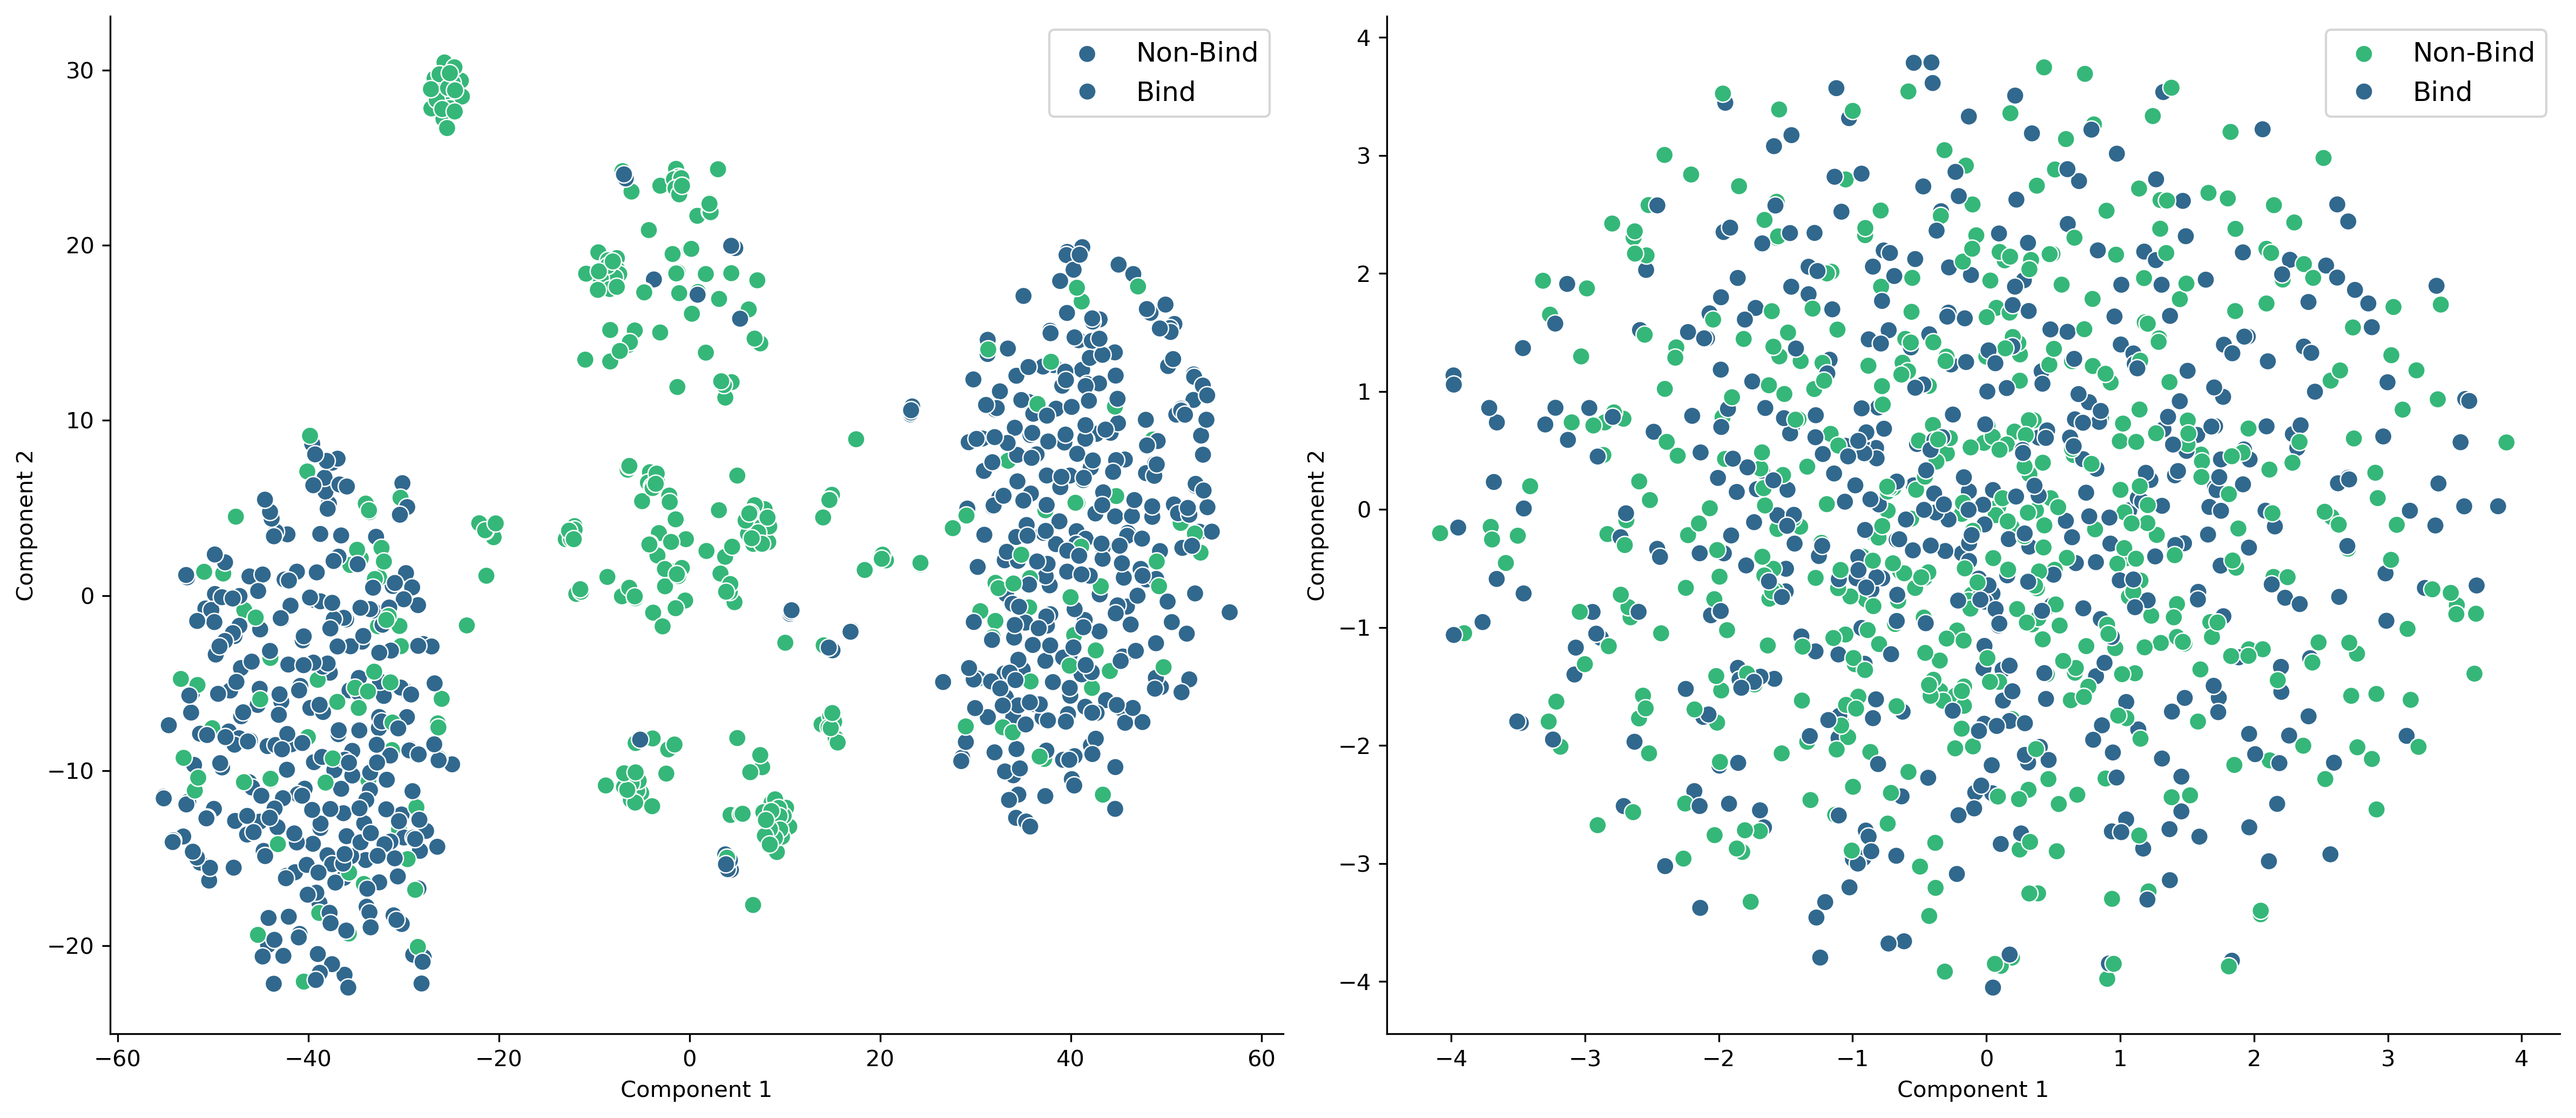

In [38]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 7), dpi = 300)

# t-SNE plot
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis", ax=axes[0], s=60, legend="full")
# axes[0].set_title(f'with pretrain h score: {with_pretrain_h_score}')
axes[0].set_xlabel('Component 1')
axes[0].set_ylabel('Component 2')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].legend(['Non-Bind', 'Bind'], prop = {"size": 12})


sns.scatterplot(x=X_random_tsne[:, 0], y=X_random_tsne[:, 1], hue=y_random, palette="viridis", ax=axes[1], s=60, legend="full")
# axes[1].set_title(f'without pretrain h score: {without_pretrain_h_score}')
axes[1].set_xlabel('Component 1')
axes[1].set_ylabel('Component 2')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].legend(['Non-Bind', 'Bind'], prop = {"size": 12})

plt.tight_layout()
plt.show()

The metrics to evaluate the embeddings:
When the ground truth is unknown, use internal evaluation metrics including Dunn Index (DI, the higher the better), Silhouette Index (SI the higher the better, ), and Calinski Harabaz (CH, the higher the better) index, which assess the compactness and separation of clusters.

Calinski Harabaz (CH)
Cluster Tendency Score (CTS)
Hopkins Score

In [ ]:
import numpy as np
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
import numpy as np
from scipy.spatial import distance

# Generate sample data
# X, _ = make_blobs(n_samples=1000, n_features=2, centers=3, cluster_std=1.0, random_state=42)

# Fit the KMeans model
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(X)

random_labels = kmeans.fit_predict(X_random)

In [ ]:
def compute_cts(embeddings, N_S=10000, N_T=1000):
    sampled_indices = np.random.choice(len(embeddings), N_S, replace=False)
    Q = embeddings[sampled_indices]
    
    test_indices = np.random.choice(N_S, N_T, replace=False)
    T = Q[test_indices]
    
    DT = 0
    for q_i_star in T:
        distances = distance.cdist([q_i_star], Q, 'sqeuclidean')[0]
        distances[test_indices[np.where(T == q_i_star)[0][0]]] = np.inf  # exclude self
        DT += np.min(distances)
    
    q_min = np.min(Q, axis=0)
    q_max = np.max(Q, axis=0)
    U = np.random.uniform(q_min, q_max, (N_T, Q.shape[1]))
    
    DR = 0
    for u_i in U:
        distances = distance.cdist([u_i], Q, 'sqeuclidean')[0]
        DR += np.min(distances)
    
    CTS = 2 * max(DR / (DR + DT) - 0.5, 0)
    
    return CTS

In [41]:
def dunn_index(X, labels):
    unique_cluster_labels = np.unique(labels)
    clusters = [X[labels == label] for label in unique_cluster_labels]
    
    # Calculate intra-cluster distances (maximum distance within each cluster)
    intra_cluster_distances = [max([euclidean(x_i, x_j) for x_i in cluster for x_j in cluster])
                               for cluster in clusters]
    max_intra_cluster_distance = max(intra_cluster_distances)
    
    # Calculate inter-cluster distances (minimum distance between clusters)
    inter_cluster_distances = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            distances = [euclidean(x_i, x_j) for x_i in clusters[i] for x_j in clusters[j]]
            inter_cluster_distances.append(min(distances))
    min_inter_cluster_distance = min(inter_cluster_distances)
    
    # Calculate Dunn Index
    dunn_index_value = min_inter_cluster_distance / max_intra_cluster_distance
    return dunn_index_value

In [42]:
import numpy as np
from scipy.spatial.distance import cdist

def calculate_dunn_index(X, labels):
    # Separate the data into two clusters based on the labels
    cluster_0 = X[labels == 0]
    cluster_1 = X[labels == 1]
    
    # Compute intra-cluster distances
    intra_cluster_distances = []
    for cluster in [cluster_0, cluster_1]:
        if len(cluster) > 1:
            intra_cluster_distances.append(np.max(cdist(cluster, cluster)))
        else:
            intra_cluster_distances.append(0)
    
    # Compute inter-cluster distance
    inter_cluster_distance = np.min(cdist(cluster_0, cluster_1))
    
    # Calculate Dunn Index
    dunn_index = inter_cluster_distance / np.max(intra_cluster_distances)
    
    return dunn_index

In [43]:
# Calculate the Dunn Index
di_score = calculate_dunn_index(X, labels)
print(f'Dunn Index: {di_score}')

di_score = calculate_dunn_index(X_random, random_labels)
print(f'Dunn Index: {di_score}')

Dunn Index: 0.28369352461490926
Dunn Index: 0.8281597287149417


In [44]:
# Calculate the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Index: {ch_score}')

# Calculate the Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_random, random_labels)
print(f'Calinski-Harabasz Index: {ch_score}')


Calinski-Harabasz Index: 321.1424554260585
Calinski-Harabasz Index: 2.1691321252245377


In [45]:
# Calculate the Silhouette Index
si_score = silhouette_score(X, labels)
print(f'Silhouette Index: {si_score}')

# Calculate the Silhouette Index
si_score = silhouette_score(X_random, random_labels)
print(f'Silhouette Index: {si_score}')

Silhouette Index: 0.28642967343330383
Silhouette Index: 0.00099379259768898


In [46]:
cts = compute_cts(X, N_S = 1000, N_T = 100)
cts

0.9636950428638242

In [47]:
cts = compute_cts(X_random, N_S = 1000, N_T = 100)
cts

0.4048200079172122

In [48]:
def get_metrics(embeddings, labels):
    # Calculate the Dunn Index
    cts_score = compute_cts(embeddings, N_S = 1000, N_T = 100)
    hopkins_statistic_score = hopkins_statistic(embeddings)
    # di_score = dunn_index(embeddings, labels)
    si_score = silhouette_score(embeddings, labels)
    ch_score = calinski_harabasz_score(embeddings, labels)

    return {
        'CTS': cts_score,
        'HS': hopkins_statistic_score,
        # 'DI': di_score,
        'SI': si_score,
        'CHI': ch_score,
    }
    

In [49]:
X.shape

(1000, 1248)

In [50]:
metrics_X = get_metrics(X, labels)
metrics_random = get_metrics(X_random, random_labels)

print(f"Metrics for X: {metrics_X}, Metrics for random: {metrics_random}")

Metrics for X: {'CTS': 0.9431063500055885, 'HS': 0.8491983958409155, 'SI': 0.28642967, 'CHI': 321.1424554260585}, Metrics for random: {'CTS': 0.40528782465441715, 'HS': 0.6071139071450321, 'SI': 0.00099379259768898, 'CHI': 2.1691321252245377}


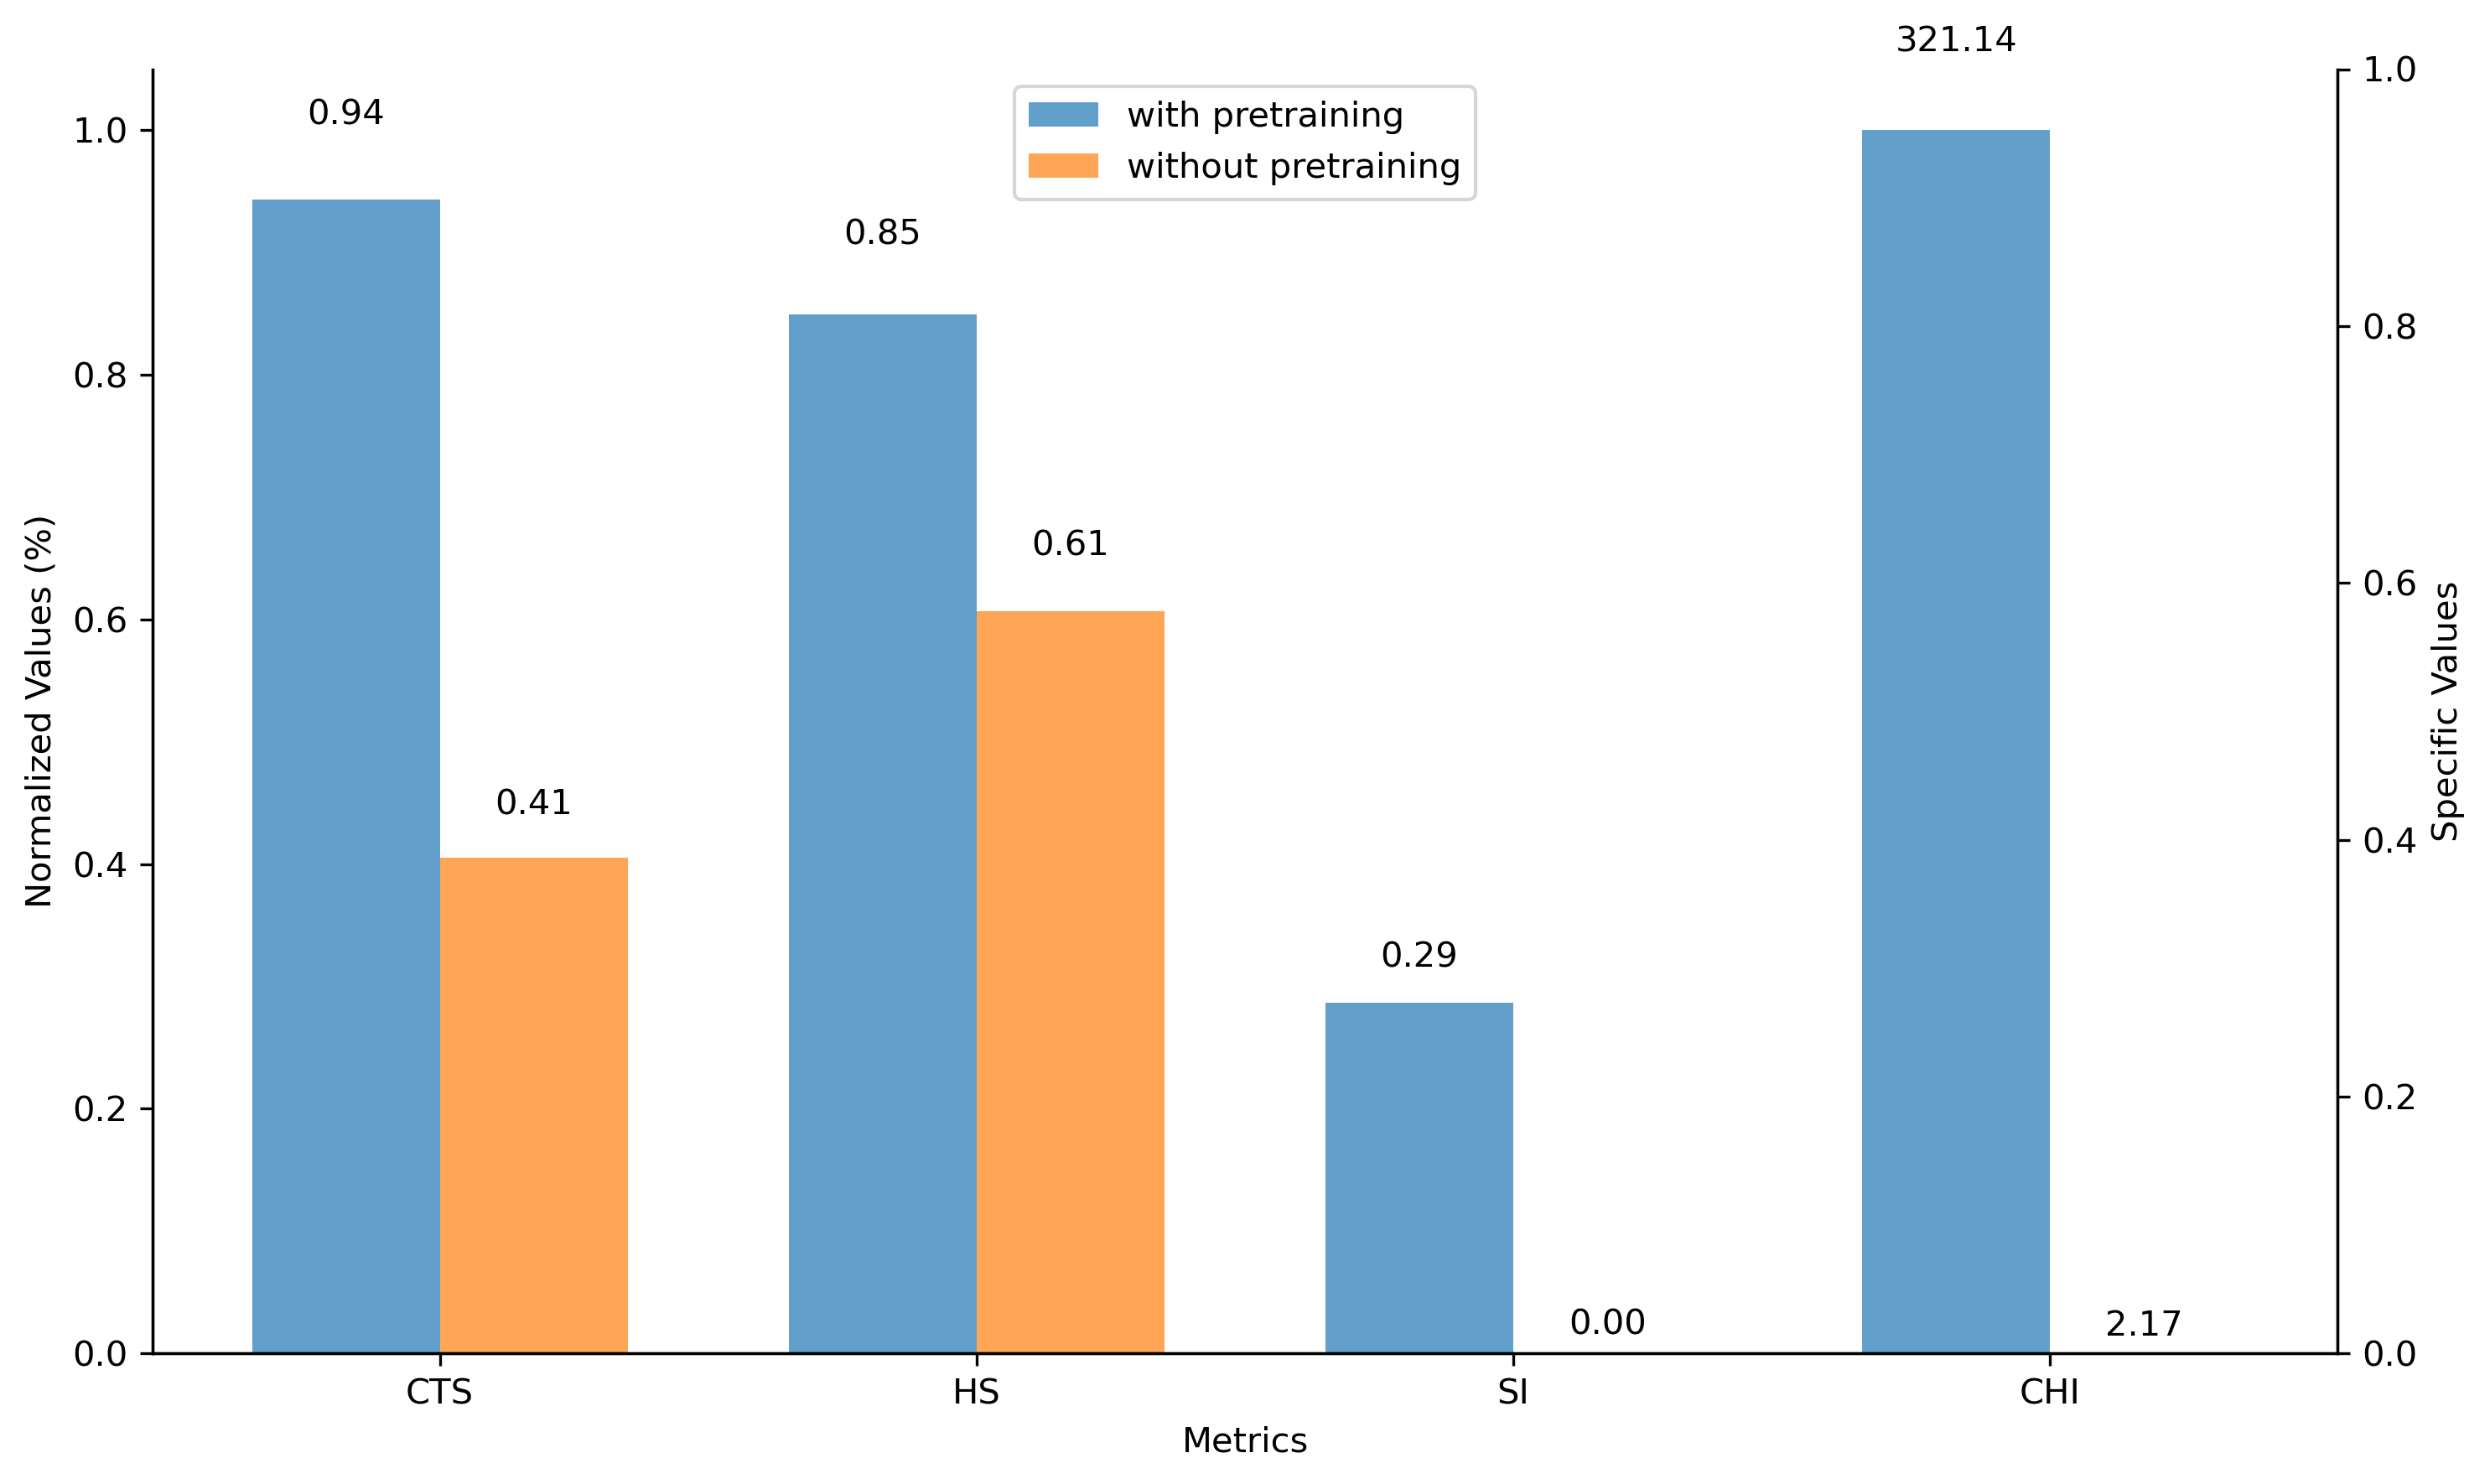

In [ ]:
def normalize_chi_score(metrics1, metrics2):
    max_chi = max(metrics1['CHI'], metrics2['CHI'])
    min_chi = min(metrics1['CHI'], metrics2['CHI'])
    if max_chi == min_chi:
        metrics1['CHI'] = 1
        metrics2['CHI'] = 1
    else:
        metrics1['CHI'] = (metrics1['CHI'] - min_chi) / (max_chi - min_chi)
        metrics2['CHI'] = (metrics2['CHI'] - min_chi) / (max_chi - min_chi)
    return metrics1, metrics2

metric_names = list(metrics_X.keys())
# Set up the bar width and positions
bar_width = 0.35
index = np.arange(len(metric_names))

normalized_metrics_X, normalized_metrics_random = normalize_chi_score(metrics_X.copy(), metrics_random.copy())

# Create a list of normalized metric values
normalized_X_values = list(normalized_metrics_X.values())
normalized_random_values = list(normalized_metrics_random.values())

# Plotting normalized metrics with specific values on the bars and dual y-axis
fig, ax1 = plt.subplots(figsize=(10, 6), dpi = 300)
ax1.spines[['top']].set_visible(False)

# Bar plot for normalized metrics
bar1 = ax1.bar(index, normalized_X_values, bar_width, label='with pretraining', alpha=0.7)
bar2 = ax1.bar(index + bar_width, normalized_random_values, bar_width, label='without pretraining', alpha=0.7)

# Add labels and title
ax1.set_xlabel('Metrics')
ax1.set_ylabel('Normalized Values (%)')
# ax1.set_title('Comparison of Normalized Metrics_X and Metrics_Random')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(metric_names)
ax1.legend(loc = 'upper center')

# Create a second y-axis to show the specific values
ax2 = ax1.twinx()
ax2.set_ylabel('Specific Values')
ax2.spines[['top']].set_visible(False)

# Display the specific values on the bars
def add_specific_values_with_axes(bars, original_values, ax):
    for bar, value in zip(bars, original_values):
        height = bar.get_height()
        ax.annotate(f'{value:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

add_specific_values_with_axes(bar1, list(metrics_X.values()), ax2)
add_specific_values_with_axes(bar2, list(metrics_random.values()), ax2)

# Show the plot
plt.tight_layout()
plt.show()

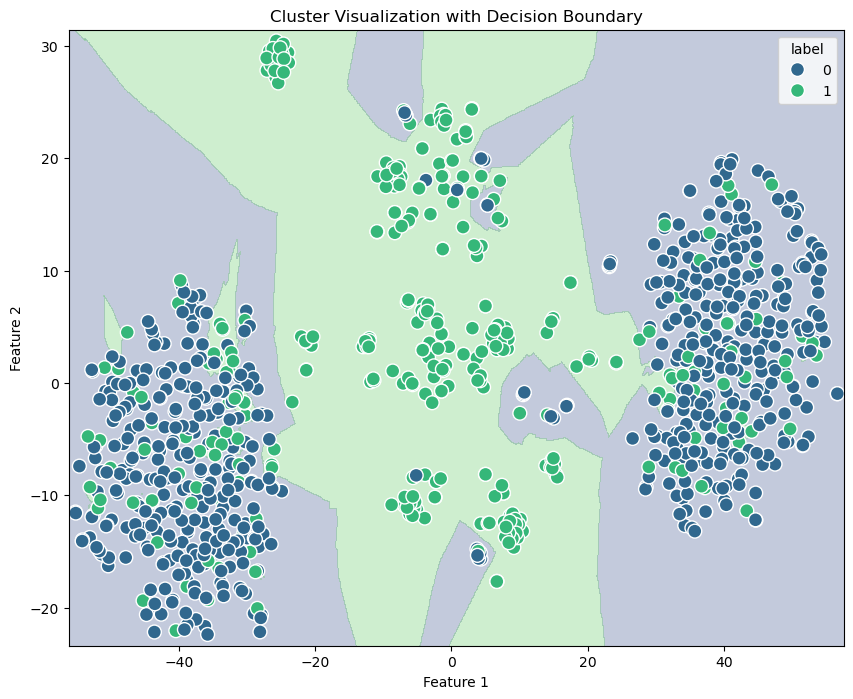

In [52]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Generating a simpler dataset
# X, y = make_blobs(n_samples=150, centers=3, cluster_std=0.5, random_state=0)
# X_tsne = tsne.fit_transform(X)
X = X_tsne

# Fit a k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)

# Create a mesh to plot the decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict classifications for each point in the mesh
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Generate the plot
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(len(np.unique(y))+1)-0.5, cmap="viridis")
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="viridis", s=100, edgecolor="w", linewidth=1)
plt.title('Cluster Visualization with Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
